In [1]:
import pickle
import os
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
    np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_STANDARD = LiH_data['experiment_data'].copy()
del LiH_data

In [5]:
STANDARD_data = experimental_data_STANDARD[101852100]['standard'].copy()
del experimental_data_STANDARD

In [6]:
len(STANDARD_data)

10

In [7]:
STANDARD_Hist_data_sim={} 
for exp_instance in STANDARD_data: #each exp repeated 10 times!
    for exp_dict_key in exp_instance:
        
        exp_dict= exp_instance[exp_dict_key]
        
        P=exp_dict['qubitOp']
        coeff = exp_dict['coeff']
        measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in STANDARD_Hist_data_sim.keys():
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': np.hstack((STANDARD_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            STANDARD_Hist_data_sim[exp_dict_key]={'P':list(P.terms.items())[0] ,'coeff': coeff.real, 'Measurements': M_list_sim}
            
        del exp_dict

In [8]:
del STANDARD_data

In [9]:
STANDARD_Hist_data_sim[0]['Measurements'].shape

(1616700,)

In [10]:
import matplotlib.pyplot as plt

In [11]:
fci_energy= -7.971184315565538

# Histogram

In [12]:
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[list(Histogram_data.keys())[0]]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [13]:
i_list_XY=[]
STANDARD_Hist_data_XY={}

i_list_Z=[]
STANDARD_Hist_data_Z={}
amplitude_min=0.00
XY_terms=[]

for key in STANDARD_Hist_data_sim:
    Pword, const = STANDARD_Hist_data_sim[key]['P']
    coeff=STANDARD_Hist_data_sim[key]['coeff']
    
    if np.abs(coeff)>amplitude_min:
        qubitNos, qubitPstrs = zip(*(list(Pword)))
        # XY terms only!
        if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
            i_list_XY.append(key)
            STANDARD_Hist_data_XY[key]=STANDARD_Hist_data_sim[key]
            XY_terms.append(STANDARD_Hist_data_sim[key]['P'])
        else:
            i_list_Z.append(key)
            STANDARD_Hist_data_Z[key]=STANDARD_Hist_data_sim[key]

In [14]:
I_term = -4.142299396835105

E_list_STANDARD_XY=Get_Hist_data(STANDARD_Hist_data_XY, 0)
E_list_STANDARD_Z=Get_Hist_data(STANDARD_Hist_data_Z, 0)

100%|██████████| 1616700/1616700 [03:00<00:00, 8951.80it/s]


In [15]:
import numpy as np

E_list_STANDARD_XY=np.array(E_list_STANDARD_XY, dtype=float).tolist()
E_list_STANDARD_Z=np.array(E_list_STANDARD_Z, dtype=float).tolist()

In [16]:
import json

In [17]:
with open("XY_STANDARD.json", "w") as write_file:
    json.dump(E_list_STANDARD_XY, write_file)
with open("Z_STANDARD.json", "w") as write_file:
    json.dump(E_list_STANDARD_Z, write_file)

In [18]:
with open("XY_STANDARD.json", "r") as read_file:
    E_list_STANDARD_XY = json.load(read_file)
with open("Z_STANDARD.json", "r") as read_file:
    E_list_STANDARD_Z = json.load(read_file)

In [19]:
E_list_STANDARD_XY=np.array(E_list_STANDARD_XY)
E_list_STANDARD_Z=np.array(E_list_STANDARD_Z)

In [20]:
len(set(E_list_STANDARD_Z))

3211

In [21]:
max(E_list_STANDARD_Z)

0.3875794934327951

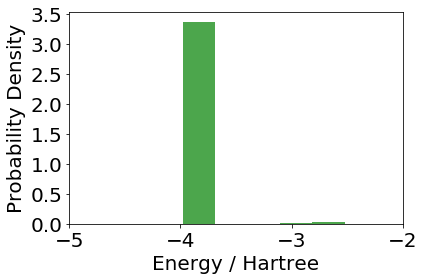

In [22]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 20

# bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_STANDARD_XY,
#                                                           bins_standard, alpha=0.7,
#                                                           label='$XY$ terms',
#                                                           color='b',
#                                                           density=False)

bin_heights_Z, bin_borders_Z, _=pyplot.hist(E_list_STANDARD_Z,
                                                          bins_standard, alpha=0.7,
                                                          label='$Z$ terms',
                                                          color='g',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-5,-1,1), fontsize=20)
pyplot.xlim((-5, -2)) 
pyplot.yticks(np.arange(0,4,0.5), fontsize=20)

pyplot.tight_layout()

file_name = 'LiH_standard_Z.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

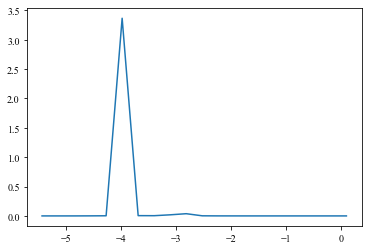

In [23]:
plt.plot(bin_borders_Z[:-1], bin_heights_Z)

<BarContainer object of 19 artists>

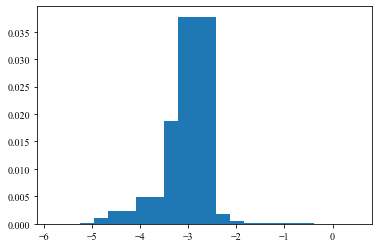

In [24]:
indices=np.where(bin_heights_Z<0.5)[0]
X=np.take(bin_borders_Z[:-1], indices)
Y=np.take(bin_heights_Z, indices)
plt.bar(X, Y)

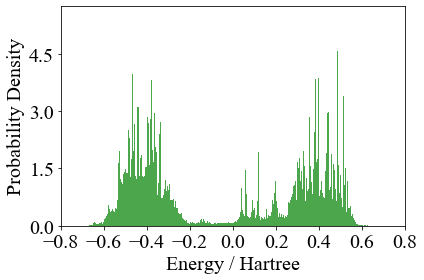

In [25]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 1000

bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_STANDARD_XY,
                                                          bins_standard, alpha=0.7,
                                                          label='$XY$ terms',
                                                          color='g',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-0.8,0.9,0.2), fontsize=20)
pyplot.xlim((-0.8, 0.8)) 
pyplot.yticks(np.arange(0,5,1.5), fontsize=20)


pyplot.tight_layout()

file_name = 'LiH_standard_XY.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

In [26]:
adsdksal;

NameError: name 'adsdksal' is not defined

In [29]:
unique, counts = np.unique(STANDARD_Hist_data_sim[0]['Measurements'], return_counts=True)
M_DICT=dict(zip(unique, counts))
M_DICT

{'0': 73, '1': 1616627}

(((0, 'Z'),), (1.0315710782693241+0j))

In [34]:
EXP_M_prob={}
for key in STANDARD_Hist_data_sim:
    Pword, const = STANDARD_Hist_data_sim[key]['P']
    
    
    unique, counts = np.unique(STANDARD_Hist_data_sim[key]['Measurements'], return_counts=True)
    M_DICT=dict(zip(unique, counts))
    
    M_prob={}
    for bitstring, Ntimes in M_DICT.items():
        parity =  1 if sum(map(int, bitstring)) % 2 == 0 else -1
        if parity in M_prob.keys():
            M_prob[parity]+=Ntimes
        else:
            M_prob[parity]=Ntimes
        
    EXP_M_prob[key]={'Sij':M_prob, 'P':QubitOperator(Pword, const)}
    

In [83]:
indices=[]
min_abs_amp = 0.51

for i in EXP_M_prob:
    Pword, const = list(EXP_M_prob[i]['P'].terms.items())[0]
    
    qubitNos, qubitPstrs = zip(*(list(Pword)))
    if ('X' in qubitPstrs) or ('Y' in qubitPstrs):
        plus=EXP_M_prob[i]['Sij'][1]
        minus=EXP_M_prob[i]['Sij'][-1]
#         if (plus-minus)>1000:
#             print(i, (plus-minus))
        if (plus/sum(EXP_M_prob[i]['Sij'].values())> min_abs_amp) or (minus/sum(EXP_M_prob[i]['Sij'].values())>min_abs_amp):
#             print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
            indices.append(i)
#             if np.abs(const)>0.01 :
#                 print(i, plus/sum(EXP_M_prob[i]['Sij'].values()))
#                 indices.append(i)
len(indices)

68

In [84]:
HIST={}

for key in indices:
    HIST[key]=STANDARD_Hist_data_sim[key]

In [85]:
E_list_HIST=Get_Hist_data(HIST, 0)

100%|██████████| 1616700/1616700 [03:10<00:00, 8487.97it/s]


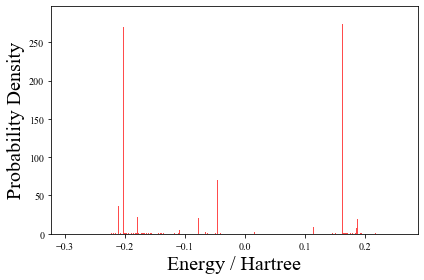

In [86]:
from matplotlib import pyplot
%matplotlib inline


# bins_standard = len(set(E_list_STANDARD_sim))
bins_standard = 1000

bin_heights_XY, bin_borders_XY, _=pyplot.hist(E_list_HIST,
                                                          bins_standard, alpha=0.7,
                                                          label='$HIST$ terms',
                                                          color='r',
                                                          density=True)

pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
# pyplot.xticks(np.arange(-0.8,0.9,0.2), fontsize=20)
# pyplot.xlim((-0.8, 0.8)) 
# pyplot.yticks(np.arange(0,5,1.5), fontsize=20)


pyplot.tight_layout()

# file_name = 'LiH_standard_XY.jpeg'
# pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()

In [ ]:
# 54% positive indices:
# [388, 389, 390, 391, 402, 403, 404, 405, 406, 407, 408, 409]

In [68]:
j=404

QubitOperator(STANDARD_Hist_data_sim[j]['P'][0], 1)

1 [X2 Z3 X4 X5 Y7 Y11]

In [73]:
for j in indices:
    print(QubitOperator(STANDARD_Hist_data_sim[j]['P'][0], 1))

1 [Y2 Z3 Y5 Y7 Z9 Y10 X11]
1 [Z1 X2 Z4 X5 Y7 Z9 Y10 X11]
1 [X2 Z3 Y5 Y7 Z9 X10 X11]
1 [Z1 Y2 Z4 X5 Y7 Z9 X10 X11]
1 [Y2 Z3 Y4 X5 Y7 Y11]
1 [Z1 X2 Y4 X5 Y7 Z9 Z10 X11]
1 [X2 Z3 X4 X5 Y7 Y11]
1 [Z1 Y2 X4 X5 Y7 Z9 Z10 X11]
1 [Y2 Z9 Y10 Z11]
1 [Z1 X2 Z3 X10]
1 [X2 Z9 X10 Z11]
1 [Z1 Y2 Z3 Y10]


NOTE all include X or Y on qubit 2 ///// X or Y on qubit 10

In [72]:
print('000000000101'[::-1])
print('010000000001'[::-1])

101000000000
100000000010


this makes exp val slightly closer to +1 

e.g.

In [71]:
alpha=np.sqrt(0.99) # ZERO
beta=np.sqrt(0.01j)  # ONE 

STATE = np.array([[alpha], [beta]])

X = cirq.X._unitary_()
Y = cirq.Y._unitary_()
Z = cirq.Z._unitary_()

print('|Ψ> = ', STATE[0,0], '|0> +', STATE[1,0], '|1>')
print('<X>: ', np.dot(STATE.conj().T, X.dot(STATE)).item(0))
print('<Y>: ',np.dot(STATE.conj().T, Y.dot(STATE)).item(0))
print('<Z>: ',np.dot(STATE.conj().T, Z.dot(STATE)).item(0))

|Ψ> =  (0.99498743710662+0j) |0> + (0.07071067811865475+0.07071067811865475j) |1>
<X>:  (0.1407124727947029+0j)
<Y>:  (0.1407124727947029+0j)
<Z>:  (0.98+0j)


101000000000
100000000010


In [55]:
indices

[388, 389, 390, 391, 402, 403, 404, 405, 406, 407, 408, 409]